# Low-Pass Filtering IMU Sample Data
This notebook loads the synthetic Sensor data from the Seeed Studio XIAO nRF52840 Sense Plus, applies a simple first-order low-pass filter to the motion signals, and visualizes the noise reduction.

## Imports and Configuration
We'll use pandas/numpy for data wrangling and Matplotlib for visualization.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use('seaborn-v0_8')


## Load the IMU Sample
The CSV stores 10 seconds of data sampled at 50 Hz.

In [4]:
DATA_PATH = Path('/Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/data/xiao_nr52840_sense_imu_sample.csv')
FS = 50.0  # sampling frequency in Hz

df = pd.read_csv(DATA_PATH)
df.head()

,timestamp_ms,accel_x_g,accel_y_g,accel_z_g,gyro_x_dps,gyro_y_dps,gyro_z_dps,mag_x_uT,mag_y_uT,mag_z_uT
0,0,0.00058,0.01295,1.00522,0.328,0.418,-0.464,11.697,-3.994,37.710
1,20,-0.00570,0.00827,0.99204,-0.348,0.782,0.158,11.913,-4.558,37.329
2,40,-0.00618,0.00251,0.99848,-0.478,-0.235,0.310,12.294,-3.968,37.433
3,60,0.00714,-0.00402,1.03565,0.018,0.339,0.380,12.026,-4.277,37.265
4,80,0.00834,-0.00644,1.01062,-0.345,-0.625,-0.421,12.273,-4.253,37.284


## Define a Low-Pass Filter
We implement a first-order infinite impulse response (IIR) low-pass filter based on an RC network. It attenuates frequencies above the chosen cutoff while preserving lower-frequency motion.

In [ ]:
def low_pass_filter(signal: np.ndarray, cutoff_hz: float, fs: float) -> np.ndarray:
    """Apply a simple first-order low-pass filter."""
    dt = 1.0 / fs
    rc = 1.0 / (2 * np.pi * cutoff_hz)
    alpha = dt / (rc + dt)
    filtered = np.zeros_like(signal)
    filtered[0] = signal[0]
    for i in range(1, len(signal)):
        filtered[i] = filtered[i - 1] + alpha * (signal[i] - filtered[i - 1])
    return filtered

cutoff_hz = 5.0  # adjust based on how aggressive you want the smoothing
columns_to_filter = [
    'accel_x_g', 'accel_y_g', 'accel_z_g',
    'gyro_x_dps', 'gyro_y_dps', 'gyro_z_dps',
    'mag_x_uT', 'mag_y_uT', 'mag_z_uT'
]

filtered_df = df.copy()
for column in columns_to_filter:
    filtered_df[column] = low_pass_filter(df[column].to_numpy(), cutoff_hz, FS)


## Compare Raw vs Filtered Signals
We'll plot accelerometer and gyroscope data to see the smoothing effect of the filter.

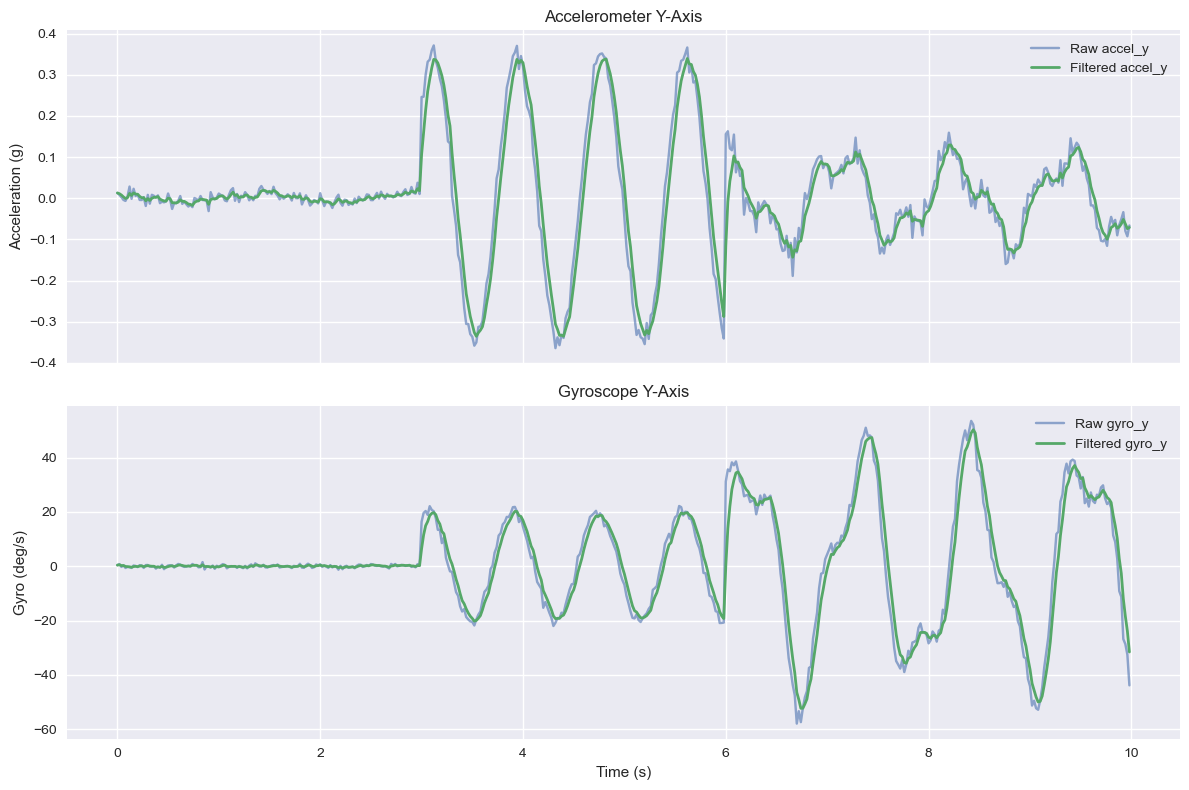

In [6]:
time_s = df['timestamp_ms'] / 1000.0

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axes[0].plot(time_s, df['accel_y_g'], label='Raw accel_y', alpha=0.6)
axes[0].plot(time_s, filtered_df['accel_y_g'], label='Filtered accel_y', linewidth=2)
axes[0].set_ylabel('Acceleration (g)')
axes[0].legend()
axes[0].set_title('Accelerometer Y-Axis')

axes[1].plot(time_s, df['gyro_y_dps'], label='Raw gyro_y', alpha=0.6)
axes[1].plot(time_s, filtered_df['gyro_y_dps'], label='Filtered gyro_y', linewidth=2)
axes[1].set_ylabel('Gyro (deg/s)')
axes[1].set_xlabel('Time (s)')
axes[1].legend()
axes[1].set_title('Gyroscope Y-Axis')

plt.tight_layout()
plt.show()


## Save Filtered Output (Optional)
You can persist the filtered signals for downstream processing.

In [ ]:
OUTPUT_PATH = Path('/Users/erickli/Desktop/Machine-Learning-for-Smart-Fitness-Pod/data/xiao_nr52840_sense_imu_sample_filtered.csv')
filtered_df.to_csv(OUTPUT_PATH, index=False)
OUTPUT_PATH

OSError: Cannot save file into a non-existent directory: 'data'